In [ ]:
import pandas as pd
import numpy as np
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.applications import DenseNet121
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.layers import Dense, Activation, Flatten, merge,Input
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras import backend as K
from keras.layers import *
from keras.callbacks import *
import os
import glob
import tensorflow as tf

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
!unzip /content/9d34462453e311ea.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Train Images/image2213.jpg  
  inflating: dataset/Train Images/image739.jpg  
  inflating: dataset/Train Images/image9406.jpg  
  inflating: dataset/Train Images/image9279.jpg  
  inflating: dataset/Train Images/image6600.jpg  
  inflating: dataset/Train Images/image6137.jpg  
  inflating: dataset/Train Images/image6158.jpg  
  inflating: dataset/Train Images/image5581.jpg  
  inflating: dataset/Train Images/image7045.jpg  
  inflating: dataset/Train Images/image3447.jpg  
  inflating: dataset/Train Images/image2005.jpg  
  inflating: dataset/Train Images/image1976.jpg  
  inflating: dataset/Train Images/image1090.jpg  
  inflating: dataset/Train Images/image3729.jpg  
  inflating: dataset/Train Images/image6098.jpg  
  inflating: dataset/Train Images/image4844.jpg  
  inflating: dataset/Train Images/image6681.jpg  
  inflating: dataset/Train Images/image4204.jpg  
  inflating: dataset/Train Images/image10055.jpg  

In [ ]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
train = pd.read_csv('dataset/train.csv')
test  = pd.read_csv('dataset/test.csv')

In [ ]:
!pip install efficientnet

In [ ]:
import efficientnet.keras as efn

In [ ]:
pt = efn.EfficientNetB7(weights = 'imagenet',include_top = False,input_shape = [192,192,3])

In [ ]:
pt.trainable = False

In [ ]:
model2 = Sequential([
        pt,
        GlobalAveragePooling2D(),
        Dense(2048, activation='relu',kernel_regularizer=keras.regularizers.l2()),
        Dropout(0.25),
        Dense(1024, activation='relu',kernel_regularizer=keras.regularizers.l2()),
        Dropout(0.25),
        Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2()),
        Dropout(0.25),
        Dense(4, activation='softmax')
    ])
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [ ]:
model2.compile(optimizer = keras.optimizers.Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[f1_m,'accuracy'])    

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False ,input_shape=[224,224,3])
vgg.trainable = True
    
model = Sequential([
        vgg,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu',use_bias = False,kernel_regularizer=keras.regularizers.l2()),
        Dropout(0.35),
        Dense(512, activation='relu',use_bias = False,kernel_regularizer=keras.regularizers.l2()),
        Dropout(0.35),
        Dense(4, activation='softmax')
    ])
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=[f1_m,'accuracy'])    

In [ ]:
!mkdir train
os.chdir('train')
!mkdir Food
!mkdir Attire
!mkdir Misc
!mkdir Decorationandsignage

In [ ]:
import shutil

In [ ]:
os.chdir('..')

In [ ]:
for i in range(len(train)):
  if train.Class[i] == 'Food':
      shutil.copyfile('dataset/Train Images/'+train.Image[i],'train/Food/'+train.Image[i])
  elif train.Class[i] == 'Attire':
      shutil.copyfile('dataset/Train Images/'+train.Image[i],'train/Attire/'+train.Image[i])
  elif train.Class[i] == 'misc':
      shutil.copyfile('dataset/Train Images/'+train.Image[i],'train/Misc/'+train.Image[i])
  elif train.Class[i] == 'Decorationandsignage':
      shutil.copyfile('dataset/Train Images/'+train.Image[i],'train/Decorationandsignage/'+train.Image[i])

In [ ]:
datagen = ImageDataGenerator(validation_split=0.2,
                             rotation_range = 10,
                             zoom_range = 0.1,
                             horizontal_flip = True)

In [ ]:
train = datagen.flow_from_directory('train',subset = 'training',target_size = (128,128))
test = datagen.flow_from_directory('train',subset = 'validation',target_size = (128,128))

Found 4788 images belonging to 4 classes.
Found 1195 images belonging to 4 classes.


In [ ]:
trainset = datagen.flow(train_imgs,train_labels,subset = 'training')
testset = datagen.flow(train_imgs,train_labels,subset = 'validation')

In [ ]:
mc = keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True)

In [ ]:
model.reset_states()

In [ ]:
model2.save_weights('init.h5')

model2.fit_generator(trainset,validation_data = testset,epochs = 5)

model.fit_generator(trainset,validation_data = testset,epochs = 5)

In [ ]:
val_datagen = ImageDataGenerator() 

In [ ]:
!mkdir test
!cp -r /content/dataset/Test\ Images test

In [ ]:
test = val_datagen.flow_from_directory('test',shuffle = False,class_mode = None,target_size=(224,224))

Found 3219 images belonging to 1 classes.


In [ ]:
model.load_weights('model.h5')

In [ ]:
preds = model.predict_generator(test)

In [ ]:
labels = (train.class_indices)

In [ ]:
labels = dict((v,k) for k,v in labels.items())


In [ ]:
predictions = [labels[k] for k in preds.argmax(axis = 1)]

In [ ]:
sub1 = pd.DataFrame()
sub1['Image'] = os.listdir('test/Test Images')
sub1['Class'] = predictions

In [ ]:
sub1.to_csv('sub4.csv',index = False)

In [ ]:
import cv2

In [ ]:
test = pd.read_csv('dataset/test.csv')

In [ ]:
train_imgs = []
train_labels = []
for i in range(len(train)):
  img = cv2.imread('dataset/Train Images/'+train.Image[i])
  img = cv2.resize(img,(224,224))
  #img = cv2.cvtColor(img,cv2.COLOR_BGR2LUV)
  img = img.astype('float32')
  img = np.array(img)
  train_imgs.append(img)
  train_labels.append(train.Class[i])

In [ ]:
test_imgs = []
for i in range(len(test)):
  img = cv2.imread('dataset/Test Images/'+test.Image[i])
  img = cv2.resize(img,(224,224))
  #img = cv2.cvtColor(img,cv2.COLOR_BGR2LUV)
  img = img.astype('float32')
  img = np.array(img)
  test_imgs.append(img)

In [ ]:
train_imgs = np.array(train_imgs)
train_labels = np.array(train_labels)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
lb = LabelBinarizer()

In [ ]:
train_labels = lb.fit_transform(train_labels)

model.reset_states()

In [ ]:
model2.layers[0].trainable = True

model2.fit(train_imgs,train_labels,epochs = 10,validation_split = 0.2)

test_labels = model2.predict(np.array(test_imgs))

In [ ]:
class_maps = train.class_indices

In [ ]:
test_labels = test_labels.argmax(axis = 1)

In [ ]:
class_maps = dict((i,j) for j,i in class_maps.items())

In [ ]:
preds = [class_maps[i] for i in test_labels]

In [ ]:
preds = lb.inverse_transform(test_labels)

In [ ]:
sub = pd.DataFrame()
sub['Image'] = test.Image

In [ ]:
sub['Class'] = preds

In [ ]:
sub.to_csv('sub14.csv',index = False)

In [ ]:
model2.fit(train_imgs,train_labels,epochs = 5,validation_split = 0.15,batch_size = 32)

Train on 5085 samples, validate on 898 samples
Epoch 1/5
5085/5085 [==============================] - 175s 34ms/step - loss: 11.8534 - f1_m: 0.8100 - acc: 0.8208 - val_loss: 2.0275 - val_f1_m: 0.7506 - val_acc: 0.7506
Epoch 2/5
5085/5085 [==============================] - 84s 17ms/step - loss: 0.9849 - f1_m: 0.9052 - acc: 0.9076 - val_loss: 1.1414 - val_f1_m: 0.7441 - val_acc: 0.7483
Epoch 3/5
5085/5085 [==============================] - 85s 17ms/step - loss: 0.4782 - f1_m: 0.9272 - acc: 0.9296 - val_loss: 0.9043 - val_f1_m: 0.7608 - val_acc: 0.7584
Epoch 4/5
5085/5085 [==============================] - 84s 17ms/step - loss: 0.3256 - f1_m: 0.9415 - acc: 0.9412 - val_loss: 0.9374 - val_f1_m: 0.7508 - val_acc: 0.7494
Epoch 5/5
5085/5085 [==============================] - 84s 17ms/step - loss: 0.2790 - f1_m: 0.9500 - acc: 0.9489 - val_loss: 0.9925 - val_f1_m: 0.7508 - val_acc: 0.7494


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, "['Decorationandsignage']")

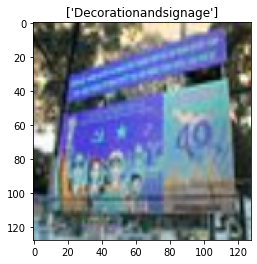

In [ ]:
i = 78
plt.imshow(train_imgs[i].astype('int'))
plt.title(lb.inverse_transform(np.array([train_labels[i]])))